In [1]:
import os
import re
import sys

import pathlib
from pathlib import Path

import sqlite3

import pandas as pd
import numpy as np

from scipy import stats

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

import pickle
import xlrd
import pylab

In [2]:
# Helper (support)
from support import input_helper

In [3]:
# Directory with IGU datasets:
ROOT_DIR = "RawData"

# Specify path to dynamic stock model and to datafile, relative
MainPath = os.path.join('odym', 'modules')
DataPath = os.path.join('docs', 'files')
sys.path.insert(0, MainPath)  # add ODYM module directory to system path

# add ODYM module directory to system path, absolute
sys.path.insert(0, os.path.join(os.getcwd(), 'odym', 'modules'))
sys.path.insert(0, os.path.join(os.getcwd(), 'docs', 'files'))

# Define path to save figures:
path_img = (
    r'C:\Users\souvi\Documents\These\90_Presentations & Writting\50_Papers\2020_Spring_MEFA of the Arch Glass Ind\IMG'
)

In [4]:
import ODYM_Classes as msc  # import the ODYM class file
import ODYM_Functions as msf  # import the ODYM function file
import dynamic_stock_model as dsm  # import the dynamic stock model library

In [5]:
# Define size of figure:
mpl.rcParams['figure.figsize'] = (16, 9)

In [6]:
# Define seaborn main parameters:
sns.set_style("ticks")
sns.color_palette("colorblind")
sns.set_context("notebook", font_scale=1)

In [7]:
pd.set_option('precision', 2)

# Upload Datasets

In [8]:
BE_data = input_helper.get_data(
    'BE_IGU_RawData_VPython.xlsx', directory=ROOT_DIR)
FR_data = input_helper.get_data(
    'FR_IGU_RawData_VPython.xlsx', directory=ROOT_DIR)
EU_data = input_helper.get_data(
    'EU_IGU_RawData_VPython.xlsx', directory=ROOT_DIR)

In [9]:
print("BE_data, sheet names = \n {}\n".format(BE_data.sheet_names))
print("FR_data, sheet names = \n {}\n".format(FR_data.sheet_names))
print("EU_data, sheet names = \n {}\n".format(EU_data.sheet_names))

BE_data, sheet names = 
 ['stock', 'consumption', 'prod', 'import', 'export', 'workforce', 'FlatGlassInd_GlassInd', 'RawMat_GlassInd_ABS', 'Population']

FR_data, sheet names = 
 ['References', 'prod', 'import', 'export', 'Population', 'MatEnergy_WindowGlass', 'MatEnergy_PlateGlass', 'RawMat_Intensity', 'Energy_Intensity', 'emissions']

EU_data, sheet names = 
 ['stock', 'consumption', 'prod', 'import', 'export', 'workforce', 'EnergyUse', 'pollution', 'production costs']



# Material, Energy and Carbon Intensity in the Flat Glass Industry

## Material intensity since 1945

In [10]:
# Create a DataFrame for material intensity:
MatIntensity = FR_data.parse('RawMat_Intensity').set_index('year')

MatIntensity['cullet, kg/kg'] = (MatIntensity['internal cullet, kg/kg']
                                 + MatIntensity['external cullet, kg/kg'])

In [12]:
# Interpolate the dataset for raw material intensity:
MatIntensity = MatIntensity.interpolate(method='pchip',
                                        limit_direction='forward')

In [13]:
# List of raw materials:
materials = ['cullet', 'sand', 'sodium carbonate',
             'limestone', 'dolomite', 'feldspar']

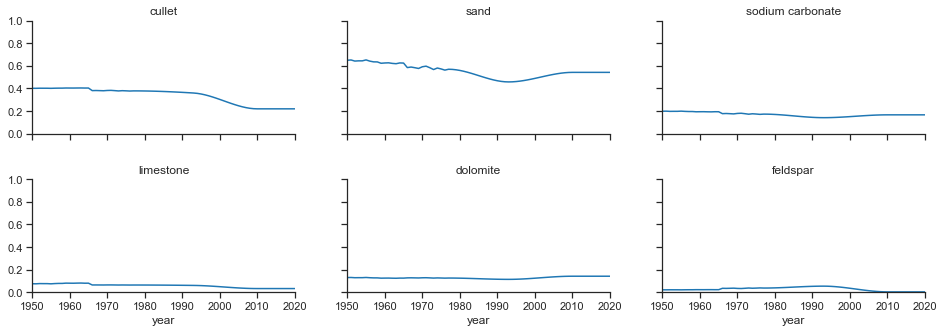

In [14]:
# Plot raw materials intensity since 1945:
fig, axes = plt.subplots(nrows=2, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):

    ax.set_title(mat)
    MatIntensity[(f"{mat}, kg/kg")].plot(ax=ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 1)

fig.subplots_adjust(hspace=0.4)

sns.despine()
plt.show()

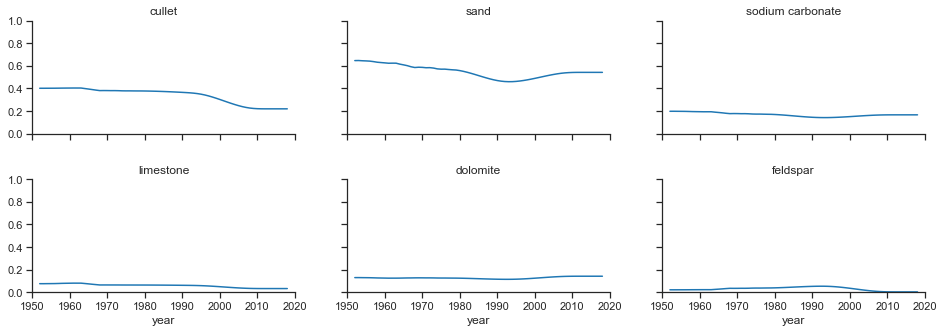

In [15]:
# Average mean of raw materials intensity since 1945:
fig, axes = plt.subplots(nrows=2, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):

    ax.set_title(mat)
    (MatIntensity[(f"{mat}, kg/kg")]
     .rolling(5, center=True).mean()
     .plot(ax=ax)
     )

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 1)

fig.subplots_adjust(hspace=0.4)

sns.despine()
plt.show()

In [16]:
# Calculate the total intensity of raw material use:
MatIntensity['Total raw materials, kg/kg'] = 0

for mat in materials:
    MatIntensity['Total raw materials, kg/kg'] = (
        MatIntensity[(f"{mat}, kg/kg")]
        + MatIntensity['Total raw materials, kg/kg']
    )

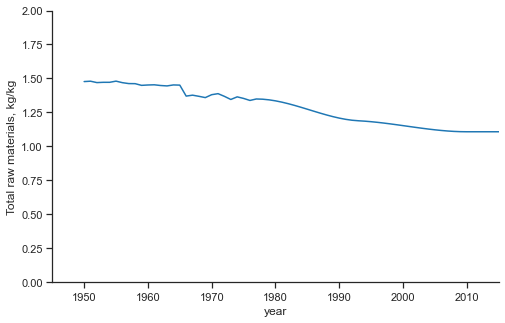

In [17]:
# Plot total intensity of raw material use:
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data=MatIntensity,
             x=MatIntensity.index,
             y='Total raw materials, kg/kg',
             ax=ax)

ax.set_xlim(1945, 2015)
ax.set_ylim(0, 2)
sns.despine()
plt.show()

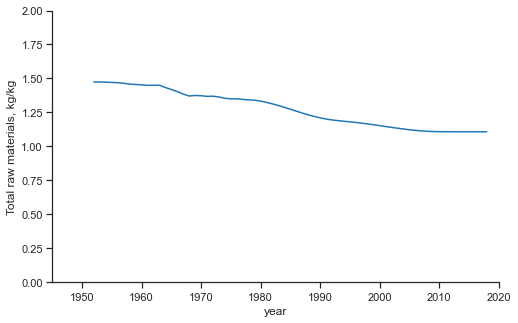

In [18]:
# Mean average and plotting total intensity of raw material use:
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data=MatIntensity,
             x=MatIntensity.index,
             y=(MatIntensity['Total raw materials, kg/kg']
                 .rolling(5, center=True).mean()),
             ax=ax)

ax.set_xlim(1945, 2020)
ax.set_ylim(0, 2)
sns.despine()
plt.show()

## Energy Intensity since 1945

In [19]:
# Create a DataFrame for energy intensity:
EnergyIntensity = FR_data.parse('Energy_Intensity').set_index('year')

In [20]:
# Interpolate the energy intensity dataset:
EnergyIntensity = EnergyIntensity.interpolate(method='pchip',
                                              limit_direction='forward')

In [21]:
# List of energies:
energies = ['fuel', 'natural gas', 'electricity']

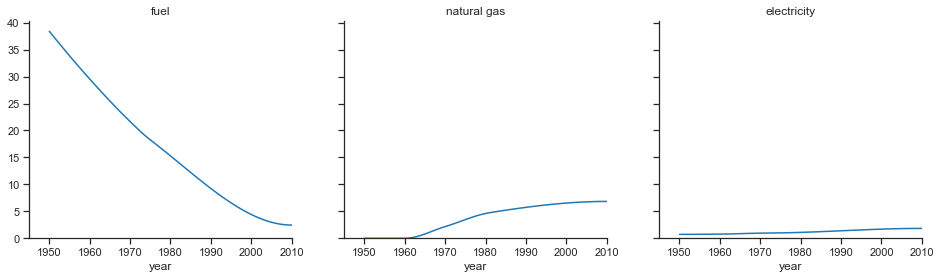

In [22]:
# Plot energy intensities:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    ax.set_title(energy)
    EnergyIntensity[(f"{energy}, GJ/t")].plot(ax=ax)

ax.set_xlim(1945, 2010)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

In [23]:
# Calculate the total intensity of energy use:
EnergyIntensity['Total energy, GJ/t'] = 0

for energy in energies:
    EnergyIntensity['Total energy, GJ/t'] = (
        EnergyIntensity['Total energy, GJ/t']
        + EnergyIntensity[(f"{energy}, GJ/t")]
    )

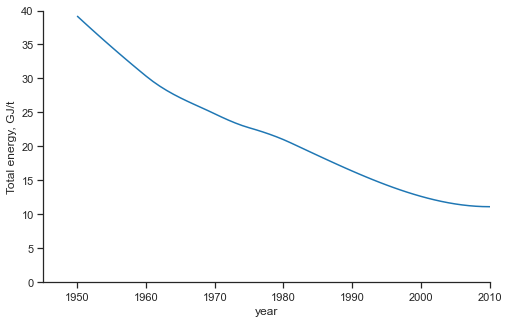

In [24]:
# Plot the total intensity of energy use:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=EnergyIntensity,
             x=EnergyIntensity.index,
             y='Total energy, GJ/t',
             ax=ax)

ax.set_xlim(1945, 2010)
ax.set_ylim(0, 40)
sns.despine()
plt.show()

In [25]:
for energy in energies:
    EnergyIntensity[(f"{energy}, %")] = 0

    for energy in energies:
        EnergyIntensity[(f"{energy}, %")] = (
            EnergyIntensity[(f"{energy}, GJ/t")]
            / EnergyIntensity['Total energy, GJ/t']
        )

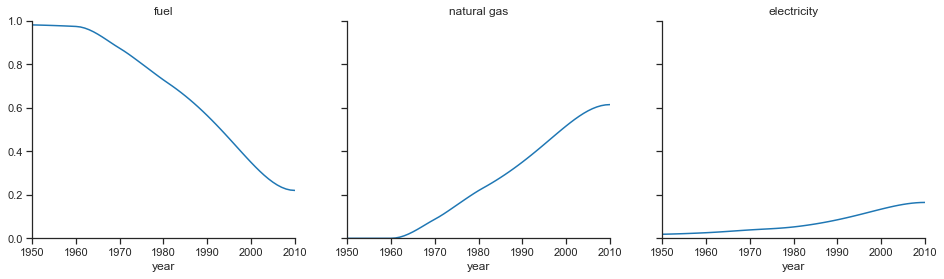

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):

    ax.set_title(energy)
    EnergyIntensity[(f"{energy}, %")].plot(ax=ax)

ax.set_xlim(1950, 2010)
ax.set_ylim(0, 1)
sns.despine()
plt.show()

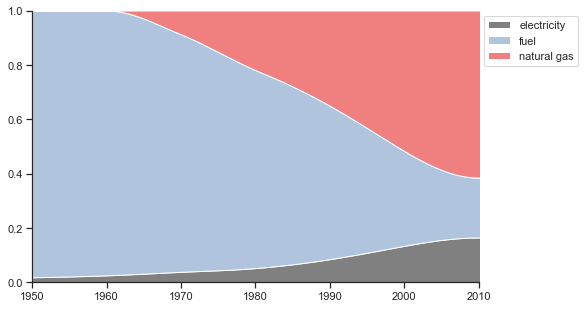

In [27]:
fig, ax = plt.subplots(figsize=(8, 5))

y = np.array([EnergyIntensity['electricity, %'].dropna(),
              EnergyIntensity['fuel, %'].dropna(),
              EnergyIntensity['natural gas, %'].dropna()]
             )

x = range(1950, 2021)

plt.stackplot(x, y,
              labels=['electricity', 'fuel', 'natural gas'],
              colors=["grey", "lightsteelblue", "lightcoral"])
plt.legend(loc='upper left')

ax.set_xlim(1950, 2010)
ax.set_ylim(0, 1)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
sns.despine()
plt.show()

##  Carbon Intensity of the Flat Glass Production Process

In [28]:
# Creating a DataFrame only with CO2 emission data
Emissions = FR_data.parse('emissions').set_index('year')

CO2_Intensity = Emissions[['CO2 glass ind, kg/t']].copy()
CO2_Intensity.rename(columns={'CO2 glass ind, kg/t': 'CO2 [kg/t]'},
                     inplace=True)

CO2_Intensity.dropna()

,CO2 [kg/t]
year,
1947,2100.0
1950,2050.0
1960,1725.0
1965,1525.0
1970,1340.0
1975,1075.0
1980,900.0
1985,800.0
1990,690.0


In [29]:
CO2_Intensity['CO2 interpolated [kg/t]'] = (
    CO2_Intensity['CO2 [kg/t]'].interpolate('pchip')
)

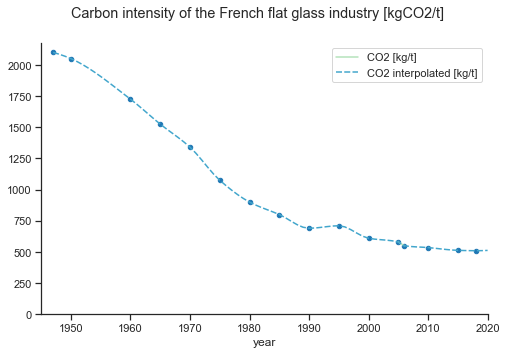

In [114]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=CO2_Intensity, palette="GnBu")

ax.scatter(x=CO2_Intensity.index, y=CO2_Intensity['CO2 [kg/t]'],
           s=20)

ax.set_xlim(1945, 2020)
ax.set_ylim(ymin=0)
fig.suptitle("Carbon intensity of the French flat glass industry [kgCO2/t]")
sns.despine()
plt.show()

## Summary

In [31]:
# Function to quickly define width of axis:
def style_ax(ax):
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.tick_params(width=0.5)
        ax.set_xlabel(None)
    return ax

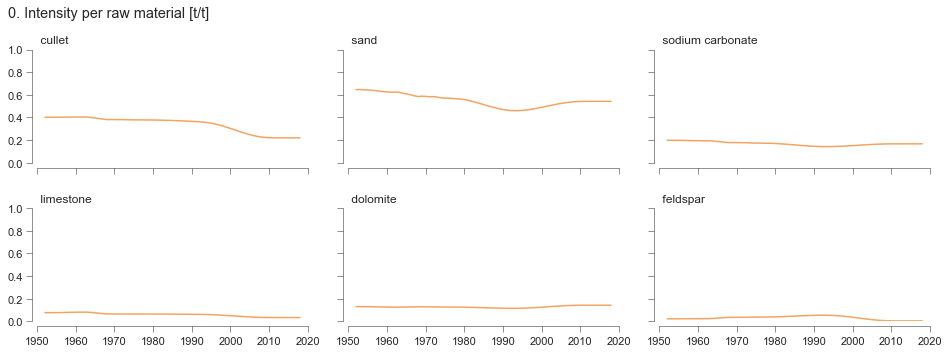

In [32]:
# Plot the material instensity per raw material:
fig, axes = plt.subplots(nrows=2, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):
    (MatIntensity[(f"{mat}, kg/kg")]
     .rolling(5, center=True).mean()
     .plot(ax=ax, c='sandybrown')
     )
    ax.set_title(f" {mat}", loc='left')
    style_ax(ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 1)

fig.suptitle("0. Intensity per raw material [t/t]", x=0.1, y=1, ha='left')
fig.subplots_adjust(wspace=0.15, hspace=0.4)
sns.despine(offset=5)

#fig.savefig(os.path.join(path_img, 'Mat Intensity.png'), dpi=600)

plt.show()

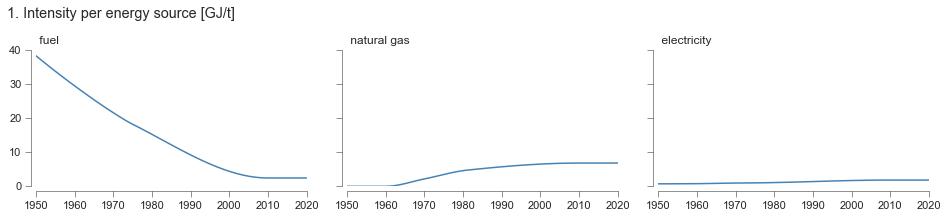

In [33]:
# Plot the energy intensity per source of energy:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 2.5)
                         )

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    EnergyIntensity[(f"{energy}, GJ/t")].plot(ax=ax, color='steelblue')
    ax.set_title(f" {energy}", loc='left')
    style_ax(ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 40)

fig.suptitle("1. Intensity per energy source [GJ/t]",
             x=0.1, y=1.12, ha='left')
fig.subplots_adjust(wspace=0.15)
sns.despine(offset=5)

fig.savefig(os.path.join(path_img, 'Energy Intensity.png'), dpi=600)

plt.show()

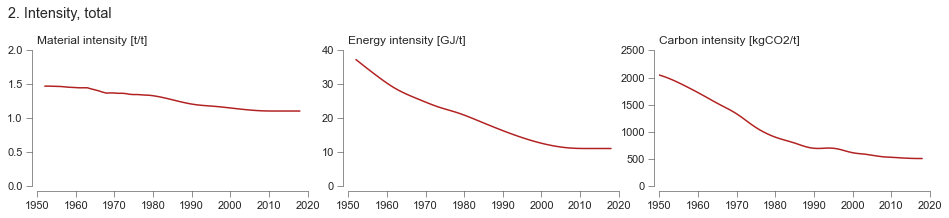

In [34]:
# Plot the intensity for energy, material and CO2 emissions:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True,
                         figsize=(16, 2.5))

# Material intensity
ax = axes[0]
(MatIntensity['Total raw materials, kg/kg'].rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick')
 )
ax.set_title("Material intensity [t/t]", loc='left')
style_ax(ax)
ax.set_ylim(0, 2)
ax.set_xlim(1950, 2020)

# Energy intensity
ax = axes[1]
(EnergyIntensity['Total energy, GJ/t'].rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick')
 )
ax.set_title("Energy intensity [GJ/t]", loc='left')
style_ax(ax)
ax.set_ylim(0, 40)

# Carbon intensity
ax = axes[2]
(CO2_Intensity['CO2 interpolated [kg/t]'].rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick')
 )
ax.set_title("Carbon intensity [kgCO2/t]", loc='left')
style_ax(ax)
ax.set_ylim(0, 2500)

fig.suptitle("2. Intensity, total", x=0.1, y=1.12, ha='left')
fig.subplots_adjust(wspace=0.15)
sns.despine(offset=5)

# plt.savefig(os.path.join(path_img, 'CO2 Intensity.png'), dpi=600)

plt.show()

# Flows of Insulating Glass Units in Europe

## Creating a Dataframe for the Flows of IGU

In [35]:
# Data relating to flat glass production:
EU_Prod = EU_data.parse('prod').set_index(['Nbr of countries', 'year'])

In [36]:
# Add import and export flows:
EU_Imp = EU_data.parse('import').set_index(['Nbr of countries', 'year'])
EU_Exp = EU_data.parse('export').set_index(['Nbr of countries', 'year'])

In [37]:
# Create a new DataFrame for European IGU flows:
EU_IGU = pd.concat([EU_Prod['IGU, "000 m²']/1000,
                    EU_Imp['IGU, "000 m²']/1000,
                    EU_Exp['IGU, "000 m²']/1000],
                   axis=1, keys=['Production [10^6 m²]',
                                 'Import [10^6 m²]',
                                 'Export [10^6 m²]'],
                   names=['Flow']).stack(dropna=False)

EU_IGU = EU_IGU.unstack()

In [38]:
EU_IGU['Consumption [10^6 m²]'] = (EU_IGU['Production [10^6 m²]']
                                   + EU_IGU['Import [10^6 m²]']
                                   - EU_IGU['Export [10^6 m²]']
                                   )

In [39]:
EU_IGU

Flow                   Production [10^6 m²]  Import [10^6 m²]  \
Nbr of countries year                                           
6                1945                   NaN               NaN   
                 1946                   NaN               NaN   
                 1947                   NaN               NaN   
                 1948                   NaN               NaN   
                 1949                   NaN               NaN   
...                                     ...               ...   
28               2015                116.00              0.87   
                 2016                114.00              1.00   
                 2017                121.60              2.12   
                 2018                117.01              1.02   
                 2019                121.06              2.32   

Flow                   Export [10^6 m²]  Consumption [10^6 m²]  
Nbr of countries year                                           
6                1945               NaN                    NaN  
                 1946               NaN                    NaN  
                 1947               NaN                    NaN  
                 1948               NaN                    NaN  
                 1949               NaN                    NaN  
...                                 ...                    ...  
28               2015              2.83                 114.04  
                 2016              2.94                 112.06  
                 2017              3.41                 120.31  
                 2018              3.20                 114.84  
                 2019              3.42                 119.96  

[77 rows x 4 columns]

In [40]:
# Adding columns for data in [kt],
# to be used later for material/energy/carbon intensity
# 2500kg/m³ and in average 9mm thick

EU_IGU['Production [kt]'] = EU_IGU['Production [10^6 m²]'] * 2.5 * 9
EU_IGU['Import [kt]'] = EU_IGU['Import [10^6 m²]'] * 2.5 * 9
EU_IGU['Export [kt]'] = EU_IGU['Export [10^6 m²]'] * 2.5 * 9
EU_IGU['Consumption [kt]'] = EU_IGU['Consumption [10^6 m²]'] * 2.5 * 9

## Production of Insulating Glass Units

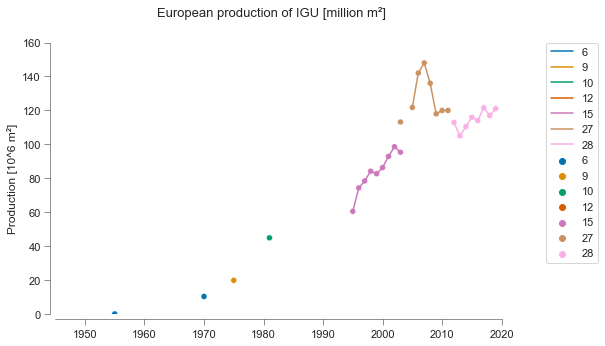

In [41]:
# Plot the European production of flat glass

fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(data=EU_IGU.reset_index(),
                x='year', y='Production [10^6 m²]',
                hue='Nbr of countries',
                palette='colorblind',
                ax=ax)

sns.lineplot(data=EU_IGU.reset_index(),
             x='year', y='Production [10^6 m²]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1945, 2020)
ax.set_ylim(0, 160)
style_ax(ax)

fig.suptitle('European production of IGU [million m²]', fontsize=13)
plt.legend(bbox_to_anchor=(1.1, 1), borderaxespad=0)
sns.despine(offset=5)
plt.show()

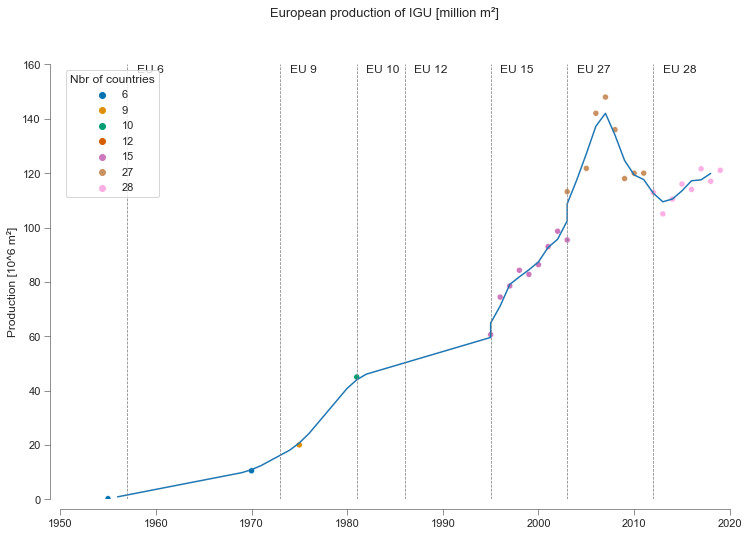

In [42]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plot EU production of IGU, 'real' data
sns.scatterplot(data=EU_IGU.reset_index(),
                x='year',
                y='Production [10^6 m²]',
                hue='Nbr of countries',
                palette='colorblind',
                ax=ax)
style_ax(ax)

# Plot a trend curve
ax.plot(EU_IGU['Production [10^6 m²]'].reset_index(level='Nbr of countries')
        .sort_values(by=['year'])
        .interpolate().rolling(3, center=True)
        .mean()['Production [10^6 m²]']
        )

# Plot lines highlightining changes in the scope, i.e. EU enlargement
EU_Kdates = {'EU 6': 1957, 'EU 9': 1973, 'EU 10': 1981, 'EU 12': 1986, 'EU 15': 1995,
             'EU 27': 2003, 'EU 28': 2012}

for y, x in EU_Kdates.items():
    plt.axvline(x=x, color='grey', linestyle='--', linewidth=0.75)
    plt.text(x+1, 160, f"{y}",
             verticalalignment='top')

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 160)

fig.suptitle('European production of IGU [million m²]', fontsize=13)
sns.despine(offset=10)

## Summary

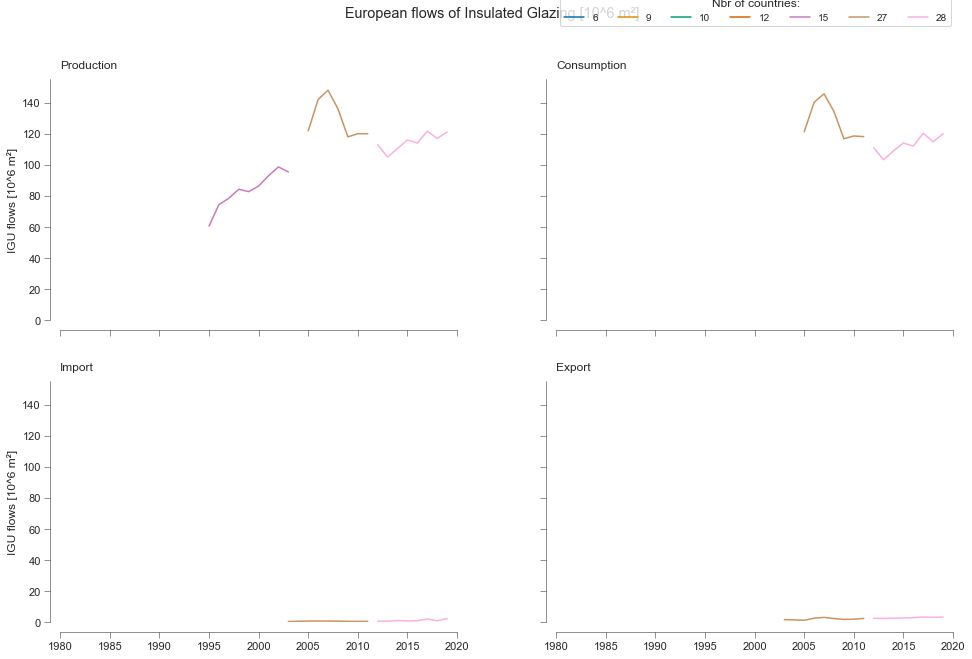

In [43]:
# Plotting import and export flows of flat glass
data1 = ['Production', 'Consumption']
data2 = ['Import', 'Export']

fig, axes = plt.subplots(nrows=2, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(16, 10))

for col, data in enumerate(data1):
    ax = axes[0][col]
    sns.lineplot(data=EU_IGU.reset_index(),
                 x='year', y=f"{data} [10^6 m²]",
                 hue='Nbr of countries',
                 palette='colorblind',
                 ax=ax)
    if col == 0:
        ax.set_ylabel('IGU flows [10^6 m²]')
    style_ax(ax)
    ax.set_title(data, pad=10, loc='left')
    ax.get_legend().remove()

for col, data in enumerate(data2):
    ax = axes[1][col]
    sns.lineplot(data=EU_IGU.reset_index(),
                 x='year', y=f"{data} [10^6 m²]",
                 hue='Nbr of countries',
                 palette='colorblind',
                 ax=ax)
    if col == 0:
        ax.set_ylabel('IGU flows [10^6 m²]')
    style_ax(ax)
    ax.set_title(data, pad=10, loc='left')
    ax.get_legend().remove()

# Add legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=7,
           fontsize='10', title='Nbr of countries:',
           bbox_to_anchor=(0.83, 0.93))

ax.set_xlim(1980, 2020)
ax.set_ylim(ymin=0)

fig.suptitle("European flows of Insulated Glazing [10^6 m²]")
fig.subplots_adjust(wspace=0.25, hspace=0.25)

sns.despine(offset=10)
plt.show()

In [44]:
EU_IGU

Flow                   Production [10^6 m²]  Import [10^6 m²]  \
Nbr of countries year                                           
6                1945                   NaN               NaN   
                 1946                   NaN               NaN   
                 1947                   NaN               NaN   
                 1948                   NaN               NaN   
                 1949                   NaN               NaN   
...                                     ...               ...   
28               2015                116.00              0.87   
                 2016                114.00              1.00   
                 2017                121.60              2.12   
                 2018                117.01              1.02   
                 2019                121.06              2.32   

Flow                   Export [10^6 m²]  Consumption [10^6 m²]  \
Nbr of countries year                                            
6                1945               NaN                    NaN   
                 1946               NaN                    NaN   
                 1947               NaN                    NaN   
                 1948               NaN                    NaN   
                 1949               NaN                    NaN   
...                                 ...                    ...   
28               2015              2.83                 114.04   
                 2016              2.94                 112.06   
                 2017              3.41                 120.31   
                 2018              3.20                 114.84   
                 2019              3.42                 119.96   

Flow                   Production [kt]  Import [kt]  Export [kt]  \
Nbr of countries year                                              
6                1945              NaN          NaN          NaN   
                 1946              NaN          NaN          NaN   
                 1947              NaN          NaN          NaN   
                 1948              NaN          NaN          NaN   
                 1949              NaN          NaN          NaN   
...                                ...          ...          ...   
28               2015          2610.00        19.66        63.76   
                 2016          2565.00        22.54        66.18   
                 2017          2736.00        47.64        76.65   
                 2018          2632.76        22.95        71.90   
                 2019          2723.88        52.15        76.85   

Flow                   Consumption [kt]  
Nbr of countries year                    
6                1945               NaN  
                 1946               NaN  
                 1947               NaN  
                 1948               NaN  
                 1949               NaN  
...                                 ...  
28               2015           2565.90  
                 2016           2521.36  
                 2017           2706.99  
                 2018           2583.80  
                 2019           2699.18  

[77 rows x 8 columns]

In [45]:
EU_list = [(6, 12), (15, 15), (27, 28)]

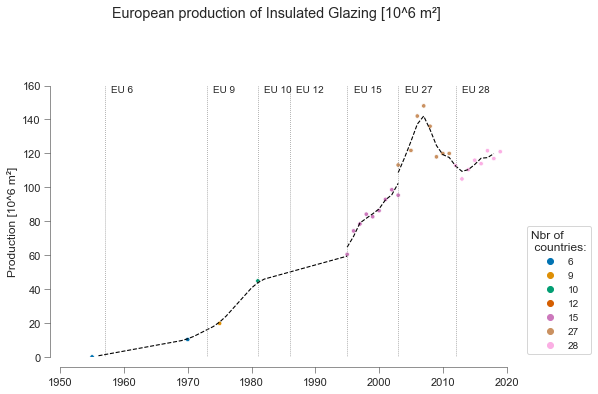

In [46]:
# Plot the European production of flat glass and only arch flat glass:
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the trend curve for flat glass production:
for i, j in EU_list:
    ax.plot(EU_IGU.interpolate().rolling(3, center=True).mean().loc[i:j]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            ['Production [10^6 m²]'],
            linewidth=1.1, c='black', linestyle='--'
            )

# Plot data gathered from literature review and calculated for arch glass:
sns.scatterplot(data=EU_IGU.reset_index(),
                x='year', y='Production [10^6 m²]',
                hue='Nbr of countries',
                palette='colorblind',
                marker='.', s=80,
                ax=ax)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper right', ncol=1,
          fontsize='10', title='Nbr of \n countries:',
          bbox_to_anchor=(1.2, 0.5))

# Plot lines highlighting changes in the scope, i.e. EU enlargement
for y, x in EU_Kdates.items():
    ax.axvline(x=x, c='grey', linestyle=':', linewidth=0.75)
    ax.text(x+1, 160, f"{y}", fontsize=10,
            verticalalignment='top')

style_ax(ax)
ax.set_xlim(1950, 2020)
ax.set_ylim(0, 160)

fig.suptitle("European production of Insulated Glazing [10^6 m²]", y=1.10)

sns.despine(offset=10)
plt.show()

# Save image
# fig.savefig(os.path.join(path_img, 'European production of flat glass.png'),
#            dpi=600)
# fig.savefig(os.path.join(path_img, 'European production of flat glass.pdf'))

# Flows of Insulating Glass Units in France and Belgium

## Creating a Dataframe for the Flows of IGU

In [47]:
# Create a DataFrame only with production data:
FR_Prod = FR_data.parse('prod').set_index('year')
BE_Prod = BE_data.parse('prod').set_index('year')

In [48]:
# Create a DataFrame with import and export data:
FR_Imp = FR_data.parse('import').set_index('year')
FR_Exp = FR_data.parse('export').set_index('year')

BE_Imp = BE_data.parse('import').set_index('year')
BE_Exp = BE_data.parse('export').set_index('year')

In [49]:
# Create a DataFrame with import and export data:
FR_Pop = FR_data.parse('Population').set_index('year')
BE_Pop = BE_data.parse('Population').set_index('year')

In [50]:
# Create a unique DataFrame for French and Belgian population:
BE_FR_Pop = pd.concat([FR_Pop['Population, x1000'],
                       BE_Pop['Population, x1000']],
                      axis=1, keys=[('Population [x1000]', 'France'),
                                    ('Population [x1000]', 'Belgium')],
                      names=['Info', 'Country']).stack()

BE_FR_Pop = BE_FR_Pop.unstack()

In [51]:
# Create a new DataFrame for Belgian and French IGU flows:
BE_FR_IGU = (
    pd.concat([FR_Prod['IGU, kt'], BE_Prod['IGU, kt'],
               FR_Prod['IGU, "000 m²'], BE_Prod['IGU, "000 m²'],
               FR_Imp['IGU, kt'], BE_Imp['IGU, kt'],
               FR_Imp['IGU, "000 m²'], BE_Imp['IGU, "000 m²'],
               FR_Exp['IGU, kt'], BE_Exp['IGU, kt'],
               FR_Exp['IGU, "000 m²'], BE_Exp['IGU, "000 m²']],
              axis=1,
              keys=[('Production [kt]', 'France'),
                    ('Production [kt]', 'Belgium'),
                    ('Production [000 m²]', 'France'),
                    ('Production [000 m²]', 'Belgium'),
                    ('Import [kt]', 'France'),
                    ('Import [kt]', 'Belgium'),
                    ('Import [000 m²]', 'France'),
                    ('Import [000 m²]', 'Belgium'),
                    ('Export [kt]', 'France'),
                    ('Export [kt]', 'Belgium'),
                    ('Export [000 m²]', 'France'),
                    ('Export [000 m²]', 'Belgium')],
              names=['Info', 'Country'])).stack(level=- 1,
                                                dropna=False)

BE_FR_IGU = BE_FR_IGU.unstack()

In [52]:
BE_FR_IGU

Info    Export [000 m²]         Export [kt]        Import [000 m²]          \
Country         Belgium  France     Belgium France         Belgium  France   
year                                                                         
1945                NaN     NaN         NaN    NaN             NaN     NaN   
1946                NaN     NaN         NaN    NaN             NaN     NaN   
1947                NaN     NaN         NaN    NaN             NaN     NaN   
1948                NaN     NaN         NaN    NaN             NaN     NaN   
1949                NaN     NaN         NaN    NaN             NaN     NaN   
...                 ...     ...         ...    ...             ...     ...   
2016             785.81  507.43       21.61  11.42          427.39  346.62   
2017             720.03  630.42       19.80  14.18          450.06  321.06   
2018             761.39  651.88       20.94  14.67          360.80  437.02   
2019                NaN  820.09         NaN  18.45          609.48  413.43   
2020                NaN     NaN         NaN    NaN             NaN     NaN   

Info    Import [kt]        Production [000 m²]           Production [kt]  \
Country     Belgium France             Belgium    France         Belgium   
year                                                                       
1945            NaN    NaN                 NaN       NaN             NaN   
1946            NaN    NaN                0.00      0.00            0.00   
1947            NaN    NaN                 NaN       NaN             NaN   
1948            NaN    NaN                 NaN       NaN             NaN   
1949            NaN    NaN                 NaN       NaN             NaN   
...             ...    ...                 ...       ...             ...   
2016           9.83   7.80             3946.62  15192.06           88.80   
2017          10.35   7.22             4192.64  15696.88           94.33   
2018           8.30   9.83             4124.61  16462.59           92.80   
2019          14.02   9.30             4349.46  17206.73           97.86   
2020            NaN    NaN                 NaN       NaN             NaN   

Info             
Country  France  
year             
1945        NaN  
1946       0.00  
1947        NaN  
1948        NaN  
1949        NaN  
...         ...  
2016     341.82  
2017     353.18  
2018     370.41  
2019     387.15  
2020        NaN  

[76 rows x 12 columns]

## Production of Insulating Glass Units

In [53]:
countries = ['Belgium', 'France']

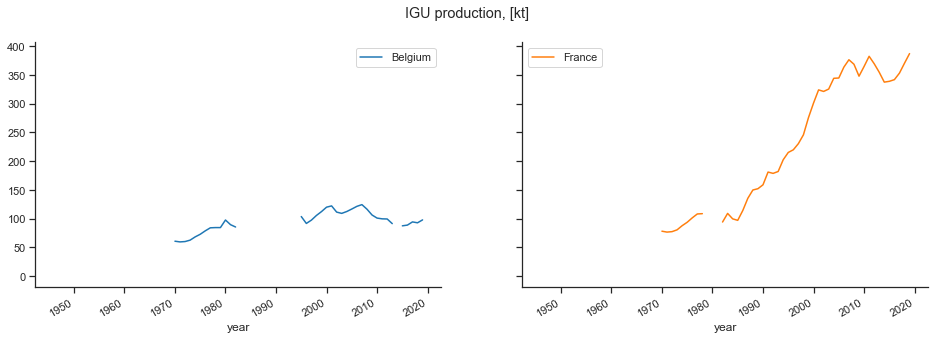

In [54]:
# Plotting the Frnech and Belgian IGU production since 1945
BE_FR_IGU['Production [kt]'].plot(subplots=True,
                                  grid=False,
                                  layout=(1, 2),
                                  figsize=(16, 5),
                                  sharex=True, sharey=True,
                                  title="IGU production, [kt]")
ax.set_xlim(1945, 2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

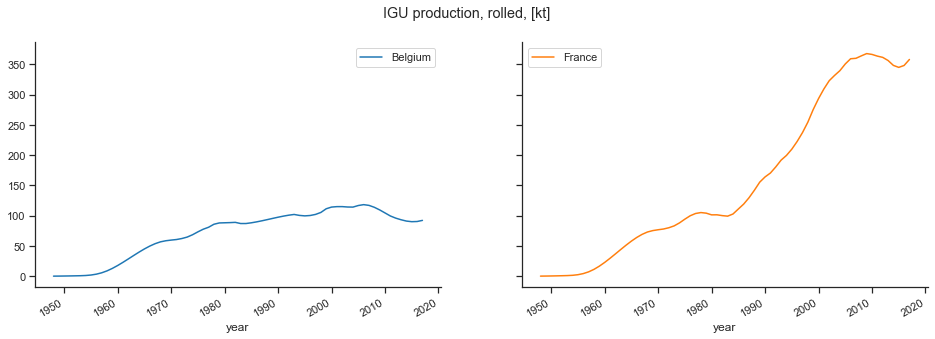

In [55]:
# Plotting the interpolated and 5-y. rolled French and Belgian IGU production
with sns.plotting_context("notebook"):
    # Linear interpolation for flat glass production
    # Rolling flat glass production according to a 5-year mean
    (BE_FR_IGU['Production [kt]']
     .interpolate(method="pchip",
                  limit_area='inside')
     .rolling(5, center=True)
     .mean()).plot(subplots=True,
                   grid=False,
                   layout=(1, 2),
                   figsize=(16, 5),
                   sharex=True, sharey=True,
                   title="IGU production, rolled, [kt]")

    ax.set_xlim(1945, 2015)
    ax.set_ylim(0, 400)
    sns.despine()
    plt.show()

In [56]:
# Interpolating and rolling of the French and Belgian IGU production
BE_FR_IGU['Production [kt]'] = (BE_FR_IGU['Production [kt]']
                                .interpolate(method="pchip",
                                             limit_area='inside')
                                )

BE_FR_IGU['Production [000 m²]'] = (BE_FR_IGU['Production [000 m²]']
                                    .interpolate(method="pchip",
                                                 limit_area='inside')
                                    )

## Consumption of Insulating Glass Units

In [57]:
ratios = ['Import', 'Export']

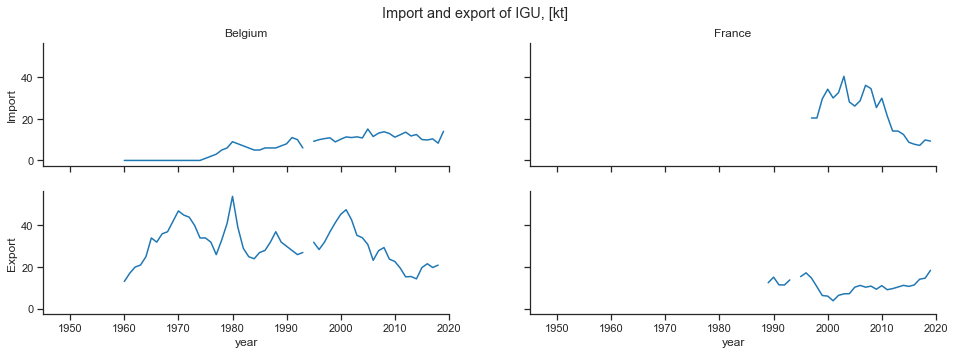

In [58]:
nrows = len(ratios)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for row, ratio in enumerate(ratios):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(ratio)
        BE_FR_IGU[(f"{ratio} [kt]", country)].plot(ax=ax)

ax.set_xlim(1945, 2020)

fig.suptitle('Import and export of IGU, [kt]')
sns.despine()
plt.show()

In [59]:
for ratio in ratios:
    BE_FR_IGU[f"{ratio} [kt]"] = (BE_FR_IGU[f"{ratio} [kt]"]
                                  .interpolate(method='linear',
                                               limit_area='inside')
                                  )

    BE_FR_IGU[f"{ratio} [000 m²]"] = (BE_FR_IGU[f"{ratio} [000 m²]"]
                                      .interpolate(method='linear',
                                                   limit_area='inside')
                                      )

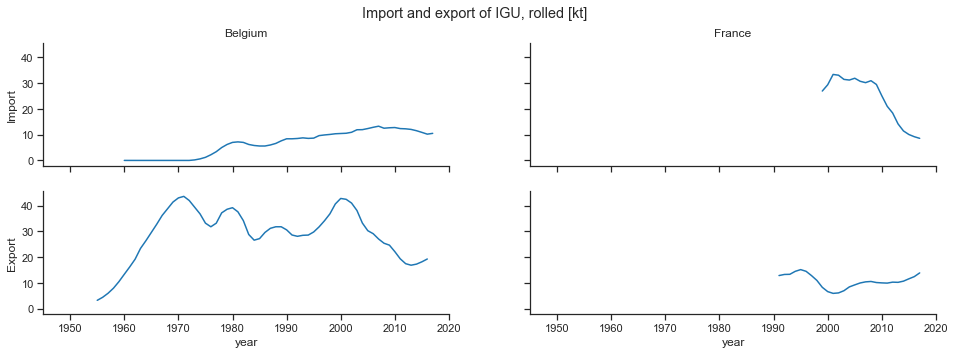

In [60]:
nrows = len(ratios)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for row, ratio in enumerate(ratios):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(ratio)
        (BE_FR_IGU[(f"{ratio} [kt]", country)]
         .rolling(5, center=True).mean()
         .plot(ax=ax)
         )

ax.set_xlim(1945, 2020)
fig.suptitle('Import and export of IGU, rolled [kt]')
sns.despine()
plt.show()

In [61]:
BE_FR_IGU = BE_FR_IGU.stack()

BE_FR_IGU['Consumption [kt]'] = (BE_FR_IGU['Production [kt]']
                                 + BE_FR_IGU['Import [kt]']
                                 - BE_FR_IGU['Export [kt]']
                                 )

BE_FR_IGU['Consumption [000 m²]'] = (BE_FR_IGU['Production [000 m²]']
                                     + BE_FR_IGU['Import [000 m²]']
                                     - BE_FR_IGU['Export [000 m²]']
                                     )

BE_FR_IGU = BE_FR_IGU.unstack()

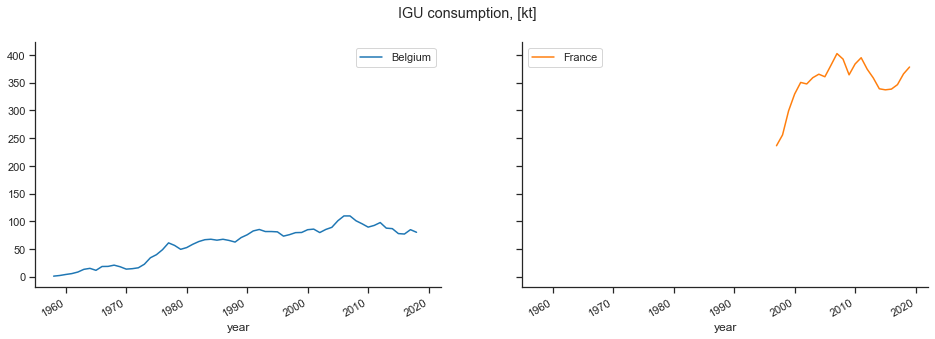

In [62]:
# Plotting the Frnech and Belgian IGU consumption since 1945
BE_FR_IGU['Consumption [kt]'].plot(subplots=True,
                                   grid=False,
                                   layout=(1, 2),
                                   figsize=(16, 5),
                                   sharex=True, sharey=True,
                                   title="IGU consumption, [kt]")

ax.set_xlim(1945, 2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

In [63]:
# Estimating the IGU consumption per capita
for country in BE_FR_IGU['Consumption [kt]'].columns:
    BE_FR_IGU[('IGU consumption [m²/cap]', country)] = (
        BE_FR_IGU[('Consumption [000 m²]', country)]
        / BE_FR_Pop[('Population [x1000]', country)])

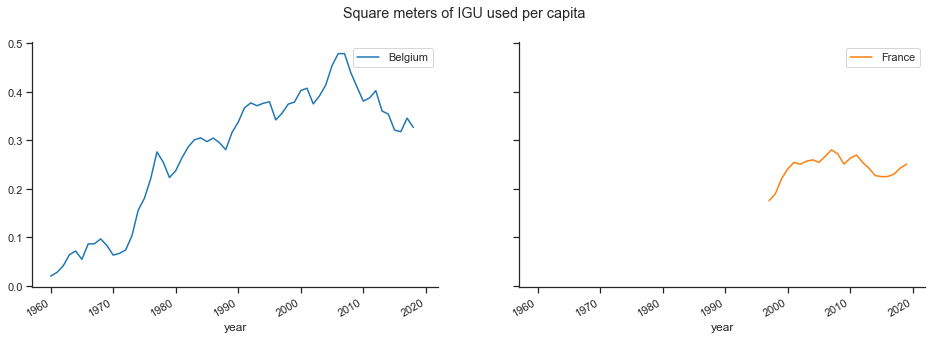

In [64]:
# Plotting the French and Belgian IGU consumption per capita
(BE_FR_IGU['IGU consumption [m²/cap]']
 .plot(subplots=True,
       grid=False,
       layout=(1, 2),
       figsize=(16, 5),
       sharex=True, sharey=True,
       title="Square meters of IGU used per capita")
 )
ax.set_xlim(1945, 2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

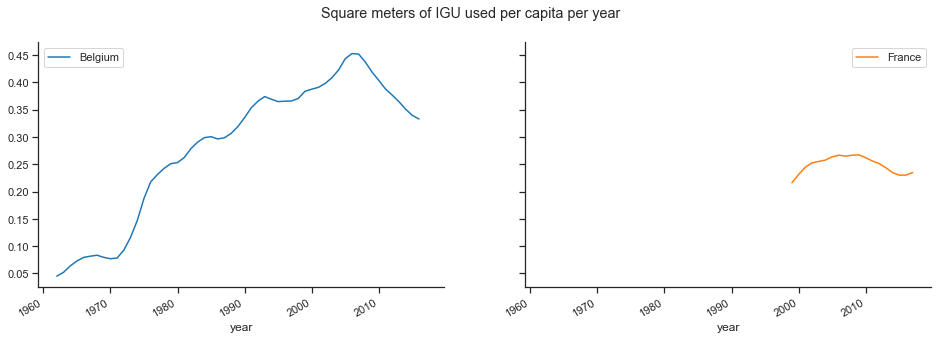

In [65]:
# Plotting the French and Belgian IGU consumption per capita
(BE_FR_IGU['IGU consumption [m²/cap]']
 .rolling(5, center=True)
 .mean()
 .plot(subplots=True,
       grid=False,
       layout=(1, 2),
       figsize=(16, 5),
       sharex=True, sharey=True,
       title="Square meters of IGU used per capita per year")
 )

ax.set_xlim(1945, 2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

# Materials, Energy and Carbon footprint of IGU used in EU

## Raw Material Use for IGU Production

In [66]:
# Absolute use of raw materials for IGU production:
for mat in materials:
    EU_IGU[f"{mat}, production [Mt]"] = (
        EU_IGU['Production [kt]'].interpolate()
        * MatIntensity[(f"{mat}, kg/kg")]/1000
    )

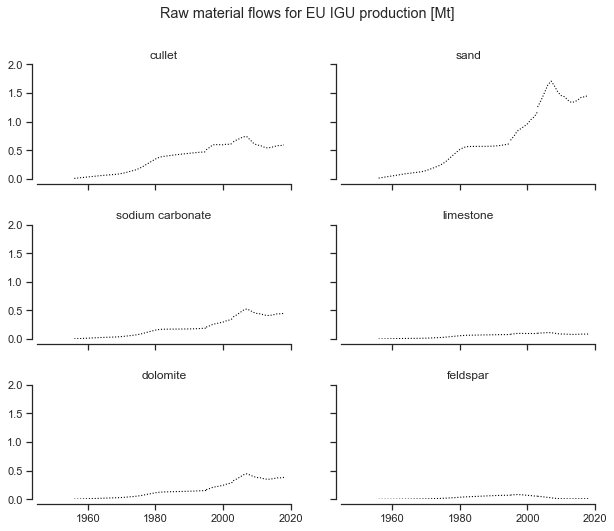

In [67]:
# Plot raw material flows for EU IGU production
fig, axes = plt.subplots(nrows=3, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(10, 8))

for i, (ax, material) in enumerate(zip(axes.flatten(), materials)):
    for a, b in EU_list:
        ax.plot(EU_IGU.rolling(3, center=True).mean().loc[a:b]
                .reset_index(level='Nbr of countries')
                .sort_values(by=['year'])
                [f"{material}, production [Mt]"],
                linewidth=1.1, c='black', linestyle=':'
                )
        ax.set_title(material)

ax.set_xlim(1945, 2020)
ax.set_ylim(0, 2)

fig.suptitle("Raw material flows for EU IGU production [Mt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

In [68]:
EU_IGU['Total raw materials, production [Mt]'] = 0

for material in materials:
    EU_IGU['Total raw materials, production [Mt]'] = (
        EU_IGU[f"{material}, production [Mt]"]
        + EU_IGU['Total raw materials, production [Mt]']
    )

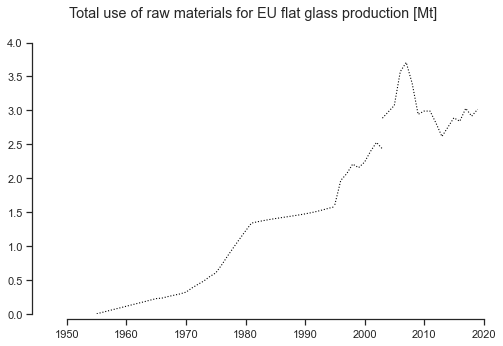

In [69]:
fig, ax = plt.subplots(figsize=(8, 5))

for a, b in EU_list:
    ax.plot(EU_IGU.loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            ['Total raw materials, production [Mt]'],
            linewidth=1.1, c='black', linestyle=':'
            )

ax.set_xlim(1945, 2020)
ax.set_ylim(0, 4)

fig.suptitle("Total use of raw materials for EU flat glass production [Mt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5, trim=True)
plt.show()

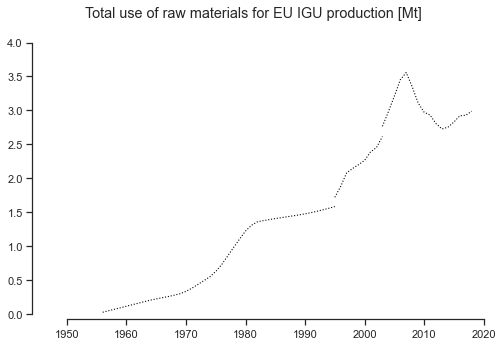

In [70]:
fig, ax = plt.subplots(figsize=(8, 5))

for a, b in EU_list:
    ax.plot(EU_IGU.rolling(3, center=True).mean().loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            ['Total raw materials, production [Mt]'],
            linewidth=1.1, c='black', linestyle=':'
            )

ax.set_xlim(1945, 2020)
ax.set_ylim(0, 4)

fig.suptitle("Total use of raw materials for EU IGU production [Mt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5, trim=True)
plt.show()

## Energy use for IGU Production

In [71]:
# Absolute use of energy for flat glass production:
for energy in energies:
    EU_IGU[f"{energy}, production [PJ]"] = (
        EU_IGU['Production [kt]']
        * EnergyIntensity[(f"{energy}, GJ/t")]/1000
    )

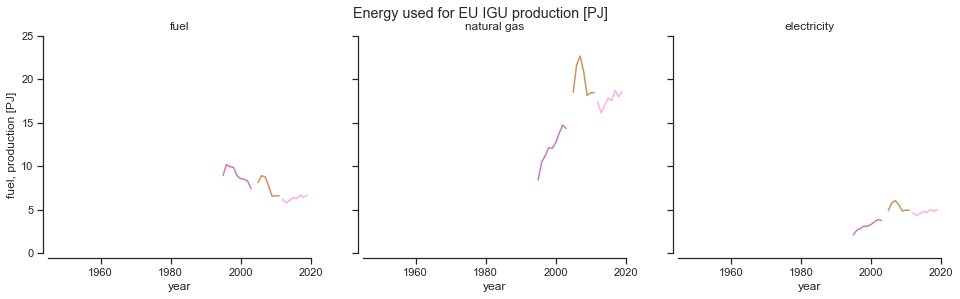

In [72]:
# Plot energy used for EU flat glass production
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    sns.lineplot(data=EU_IGU.reset_index(),
                 x='year', y=f"{energy}, production [PJ]",
                 hue='Nbr of countries',
                 palette='colorblind',
                 ax=ax)
    ax.set_title(energy)
    ax.get_legend().remove()

ax.set_xlim(1945, 2020)
ax.set_ylim(0, 25)

fig.suptitle("Energy used for EU IGU production [PJ]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

In [73]:
EU_IGU['Total energy, production [PJ]'] = 0

for energy in energies:
    EU_IGU['Total energy, production [PJ]'] = (
        EU_IGU[f"{energy}, production [PJ]"]
        + EU_IGU['Total energy, production [PJ]']
    )

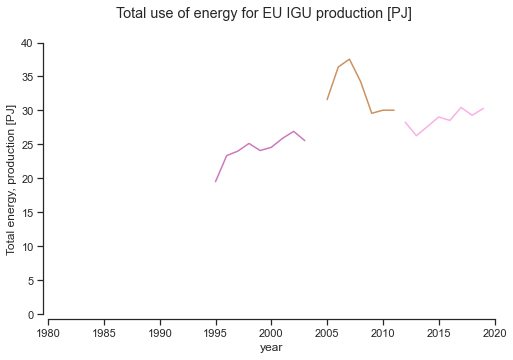

In [74]:
# Plot total energy use for EU flat glass production

fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=EU_IGU.reset_index(),
             x='year', y='Total energy, production [PJ]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1980, 2020)
ax.set_ylim(0, 40)
ax.get_legend().remove()

fig.suptitle("Total use of energy for EU IGU production [PJ]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5, trim=True)
plt.show()

In [75]:
# Absolute use of energy for flat glass production:
for energy in energies:
    EU_IGU[f"{energy}, production [PJ]"] = (
        EU_IGU['Production [kt]'].interpolate()
        * EnergyIntensity[(f"{energy}, GJ/t")]/1000
    )

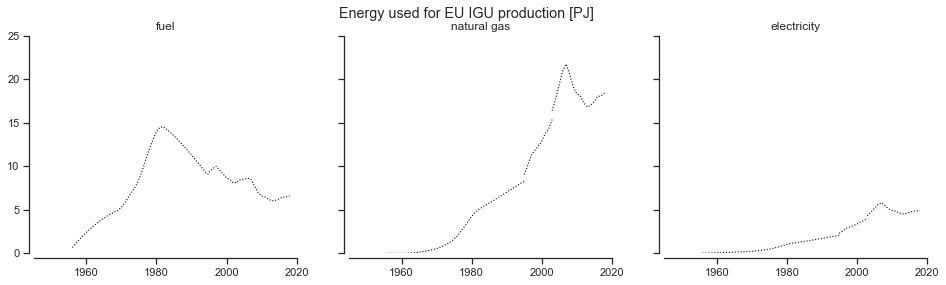

In [76]:
# Plot energy used for EU flat glass production
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    for a, b in EU_list:
        ax.plot(EU_IGU.rolling(3, center=True).mean().loc[a:b]
                .reset_index(level='Nbr of countries')
                .sort_values(by=['year'])
                [f"{energy}, production [PJ]"],
                linewidth=1.1, c='black', linestyle=':'
                )
        ax.set_title(energy)

ax.set_xlim(1945, 2020)
ax.set_ylim(0, 25)

fig.suptitle("Energy used for EU IGU production [PJ]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

In [77]:
EU_IGU['Total energy, production [PJ]'] = 0

for energy in energies:
    EU_IGU['Total energy, production [PJ]'] = (
        EU_IGU[f"{energy}, production [PJ]"]
        + EU_IGU['Total energy, production [PJ]']
    )

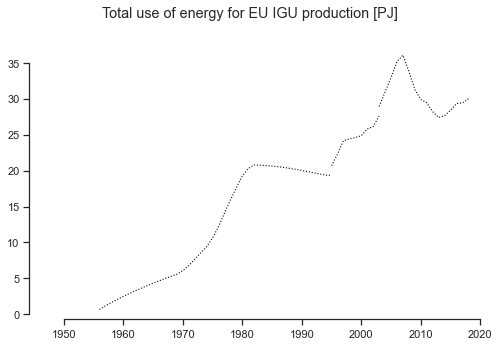

In [78]:
# Plot total energy use for EU flat glass production
fig, ax = plt.subplots(figsize=(8, 5))

for a, b in EU_list:
    ax.plot(EU_IGU.rolling(3, center=True).mean().loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            ['Total energy, production [PJ]'],
            linewidth=1.1, c='black', linestyle=':'
            )

ax.set_xlim(1945, 2020)
ax.set_ylim(ymin=0)

fig.suptitle("Total use of energy for EU IGU production [PJ]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5, trim=True)
plt.show()

## CO2 Emissions Relating to IGU Production and Consumption in EU

In [79]:
# Estimating the CO2 emission related to IGU production
EU_IGU['CO2, production [kt]'] = (
    EU_IGU['Production [kt]']
    * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000
)

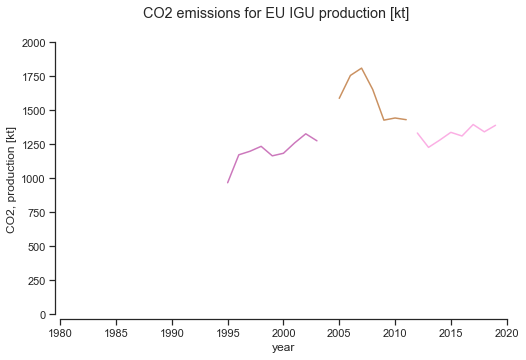

In [80]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=EU_IGU.reset_index(),
             x='year', y='CO2, production [kt]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)
ax.set_xlim(1980, 2020)
ax.set_ylim(0, 2000)
ax.get_legend().remove()

fig.suptitle("CO2 emissions for EU IGU production [kt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

In [81]:
# Estimating the CO2 emission related to IGU production
EU_IGU['CO2, production [kt]'] = (
    EU_IGU['Production [kt]'].interpolate()
    * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000
)

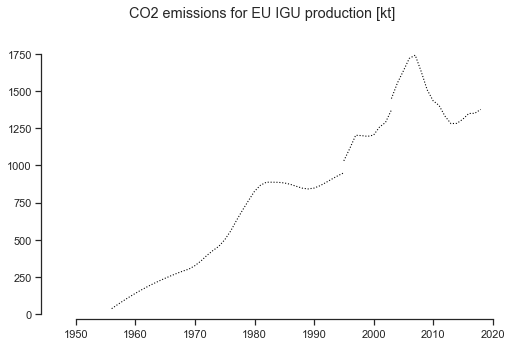

In [82]:
# Plot total energy use for EU flat glass production
fig, ax = plt.subplots(figsize=(8, 5))

for a, b in EU_list:
    ax.plot(EU_IGU.rolling(3, center=True).mean().loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            ['CO2, production [kt]'],
            linewidth=1.1, c='black', linestyle=':'
            )

ax.set_xlim(1945, 2020)
ax.set_ylim(ymin=0)

fig.suptitle("CO2 emissions for EU IGU production [kt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5, trim=True)
plt.show()

# Materials, Energy and Carbon footprint of IGU used in BE and FR

## Raw Material Use for IGU Production

In [83]:
# Absolute use of raw materials for IGU production:
for mat in materials:
    for country in BE_FR_IGU['Production [kt]'].columns:
        BE_FR_IGU[(f"{mat}, production [kt]", country)] = (
            BE_FR_IGU[('Production [kt]', country)]
            * MatIntensity[(f"{mat}, kg/kg")]
        )

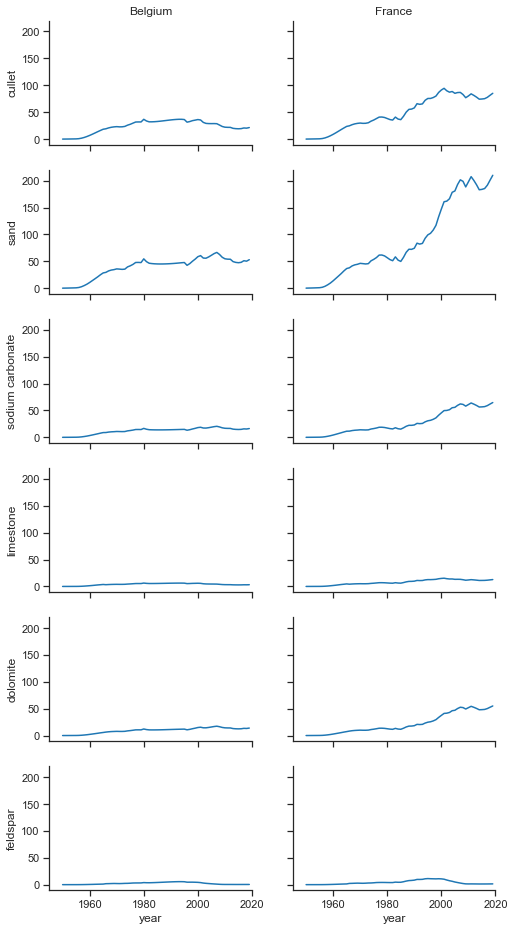

In [84]:
nrows = len(materials)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(8, 16))

for row, material in enumerate(materials):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(material)
        BE_FR_IGU[(f"{material}, production [kt]", country)].plot(ax=ax)

ax.set_xlim(1945, 2020)

sns.despine()
plt.show()

In [85]:
for country in countries:
    BE_FR_IGU[('Total raw material use, production [kt]', country)] = 0

for material in materials:
    BE_FR_IGU['Total raw material use, production [kt]'] = (
        BE_FR_IGU[f"{material}, production [kt]"]
        + BE_FR_IGU['Total raw material use, production [kt]']
    )

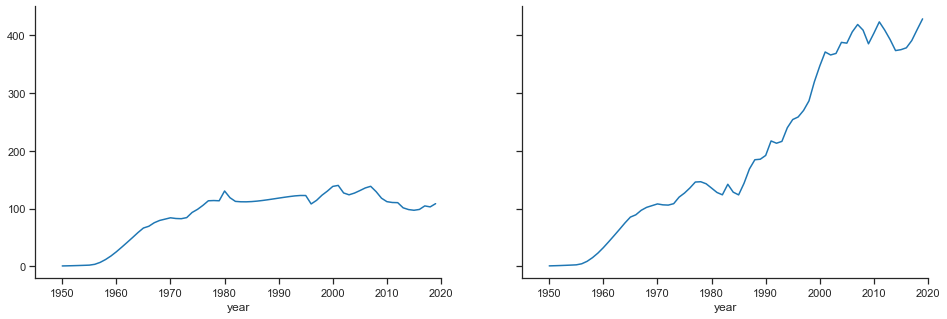

In [86]:
ncols = len(countries)

fig, axes = plt.subplots(nrows=1, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for col, country in enumerate(countries):
    ax = axes[col]
    (BE_FR_IGU[('Total raw material use, production [kt]', country)]
     .plot(ax=ax))

ax.set_xlim(1945, 2020)
sns.despine()
plt.show()

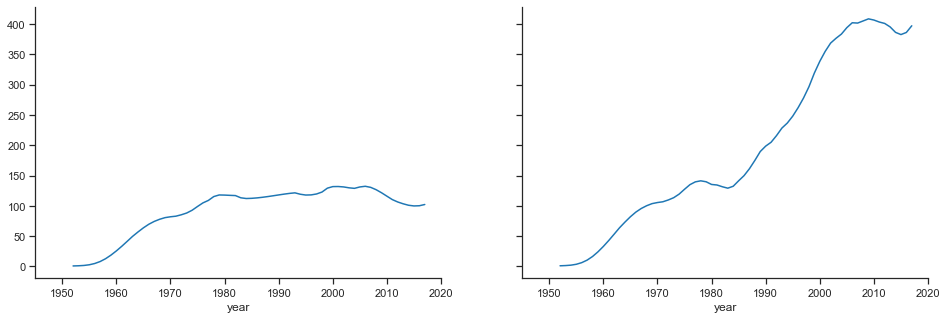

In [87]:
ncols = len(countries)

fig, axes = plt.subplots(nrows=1, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for col, country in enumerate(countries):
    ax = axes[col]
    (BE_FR_IGU[('Total raw material use, production [kt]', country)]
     .rolling(5, center=True).mean()
     .plot(ax=ax))

ax.set_xlim(1945, 2020)
sns.despine()
plt.show()

## Energy use for IGU Production

In [88]:
# Absolute use of energy for flat glass production:
for energy in energies:
    for country in countries:
        BE_FR_IGU[(f"{energy}, production [TJ]", country)] = (
            BE_FR_IGU[('Production [kt]', country)]
            * EnergyIntensity[(f"{energy}, GJ/t")]
        )

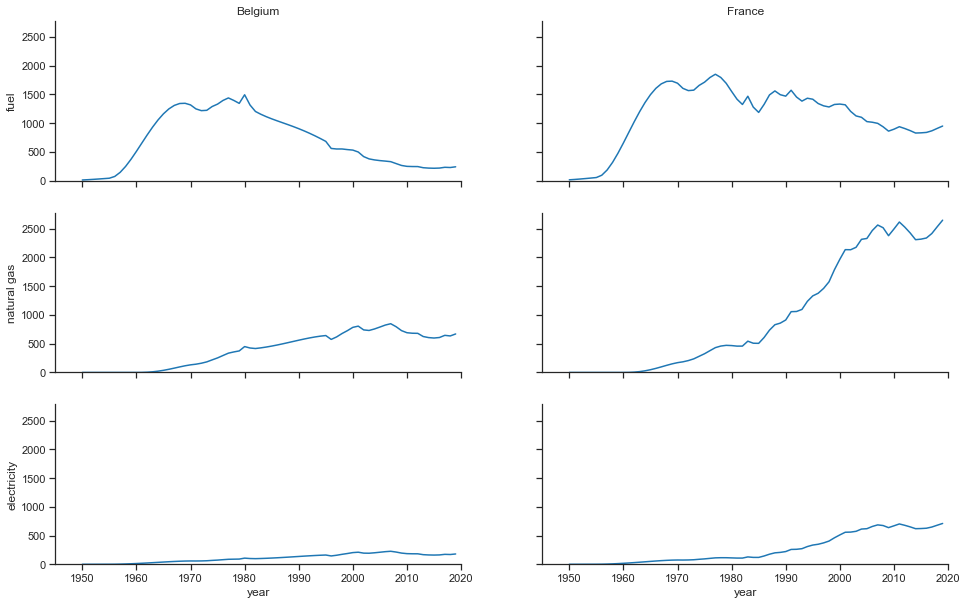

In [89]:
nrows = len(energies)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 10))
for row, energy in enumerate(energies):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(energy)
        BE_FR_IGU[(f"{energy}, production [TJ]", country)].plot(ax=ax)

ax.set_xlim(1945, 2020)
ax.set_ylim(ymin=0)

sns.despine()
plt.show()

In [90]:
for country in countries:
    BE_FR_IGU[('Total energy use, production [TJ]', country)] = 0

for energy in energies:
    BE_FR_IGU['Total energy use, production [TJ]'] = (
        BE_FR_IGU[f"{energy}, production [TJ]"]
        + BE_FR_IGU['Total energy use, production [TJ]']
    )

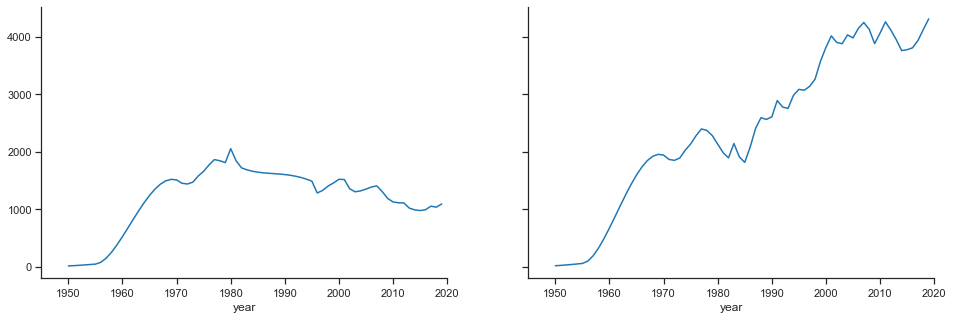

In [91]:
ncols = len(countries)

fig, axes = plt.subplots(nrows=1, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for col, country in enumerate(countries):
    ax = axes[col]
    (BE_FR_IGU[('Total energy use, production [TJ]', country)]
     .plot(ax=ax))

ax.set_xlim(1945, 2020)
sns.despine()
plt.show()

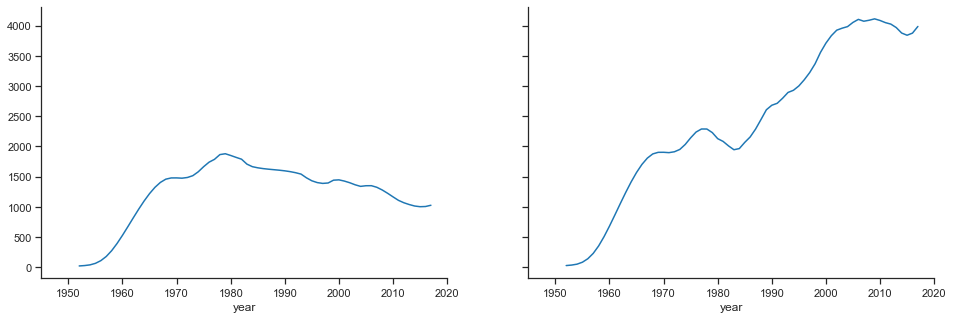

In [92]:
ncols = len(countries)

fig, axes = plt.subplots(nrows=1, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for col, country in enumerate(countries):
    ax = axes[col]
    (BE_FR_IGU[('Total energy use, production [TJ]', country)]
     .rolling(5, center=True).mean()
     .plot(ax=ax))

ax.set_xlim(1945, 2020)
sns.despine()
plt.show()

## CO2 Emissions Relating to IGU Production and Consumption in France and Belgium

In [93]:
# Estimating the CO2 emission related to IGU production
for country in BE_FR_IGU['Production [kt]'].columns:
    BE_FR_IGU[('CO2, IGU production [ktCO2]', country)] = (
        BE_FR_IGU[('Production [kt]', country)]
        * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000
    )

In [94]:
# Estimating the CO2 emission related to IGU consumption
for country in BE_FR_IGU['Consumption [kt]'].columns:
    BE_FR_IGU[('CO2, IGU consumption [ktCO2]', country)] = (
        BE_FR_IGU[('Consumption [kt]', country)]
        * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000
    )

In [95]:
CO2_IGU = ['production', 'consumption']

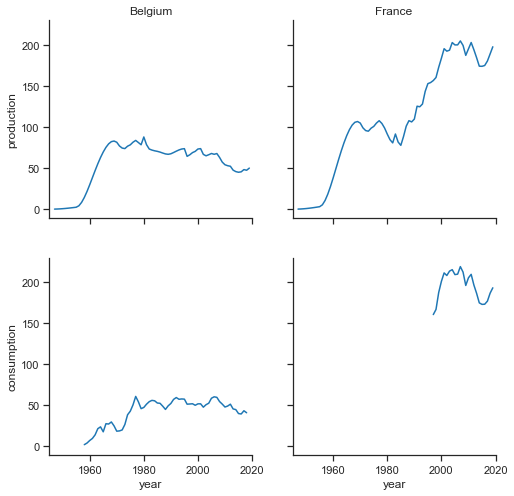

In [96]:
nrows = len(CO2_IGU)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(8, 8))

for row, CO2 in enumerate(CO2_IGU):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(CO2)
        BE_FR_IGU[(f"CO2, IGU {CO2} [ktCO2]", country)].plot(ax=ax)

ax.set_xlim(1945, 2020)

sns.despine()
plt.show()

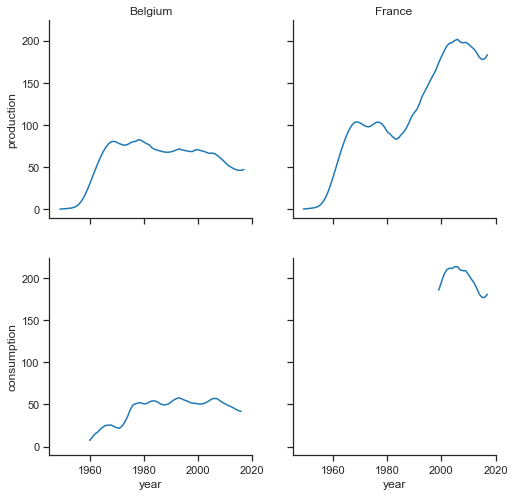

In [97]:
nrows = len(CO2_IGU)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(8, 8))

for row, CO2 in enumerate(CO2_IGU):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(CO2)
        (BE_FR_IGU[(f"CO2, IGU {CO2} [ktCO2]", country)]
         .rolling(5, center=True).mean().
         plot(ax=ax)
         )

ax.set_xlim(1945, 2020)

sns.despine()
plt.show()

## CO2 Emissions: Base 100 Analysis

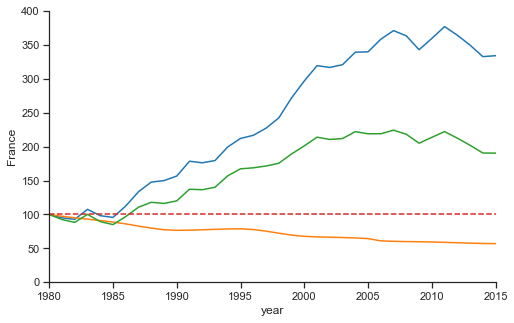

In [98]:
# Base 100 = 1980
IGUProd_diff = (100 * BE_FR_IGU['Production [kt]']
                / BE_FR_IGU['Production [kt]'].loc[1980]
                )

CO2Intensity_diff = 100 * CO2_Intensity / CO2_Intensity.loc[1980]

CO2ABS_IGUdiff = (100 * BE_FR_IGU['CO2, IGU production [ktCO2]']
                  / BE_FR_IGU['CO2, IGU production [ktCO2]'].loc[1980]
                  )

# Plotting production, carbon intensity, CO2 absolute emissions for France
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data=IGUProd_diff,
             x=IGUProd_diff.index,
             y='France',
             ax=ax)

ax.plot(CO2Intensity_diff.index,
        CO2Intensity_diff['CO2 interpolated [kg/t]'])
ax.plot(CO2ABS_IGUdiff.index,
        CO2ABS_IGUdiff['France'])

ax.plot([1980, 2015], [100, 100], '--')

ax.set_xlim(1980, 2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

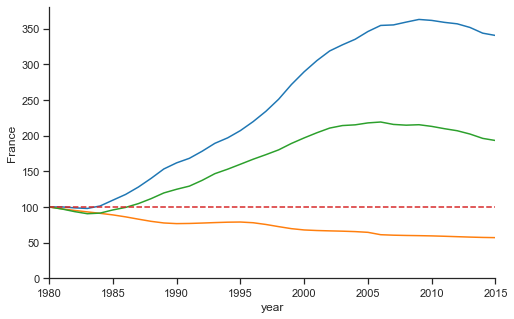

In [99]:
# Base 100 = 1980
IGUProd_diff = (100 * BE_FR_IGU['Production [kt]']
                .rolling(5, center=True).mean()
                / BE_FR_IGU['Production [kt]']
                .rolling(5, center=True).mean()
                .loc[1980]
                )

CO2Intensity_diff = 100 * CO2_Intensity / CO2_Intensity.loc[1980]

CO2ABS_IGUdiff = (100 * BE_FR_IGU['CO2, IGU production [ktCO2]']
                  .rolling(5, center=True).mean()
                  / BE_FR_IGU['CO2, IGU production [ktCO2]']
                  .rolling(5, center=True).mean()
                  .loc[1980]
                  )

# Plotting production, carbon intensity, CO2 absolute emissions for France
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data=IGUProd_diff,
             x=IGUProd_diff.index,
             y='France',
             ax=ax)

ax.plot(CO2Intensity_diff.index,
        CO2Intensity_diff['CO2 interpolated [kg/t]'])
ax.plot(CO2ABS_IGUdiff.index,
        CO2ABS_IGUdiff['France'])

ax.plot([1980, 2015], [100, 100], '--')

ax.set_xlim(1980, 2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

## Summary

# Dynamic Stock Modelling

Pauliuk and Heeren, + github and notebook

## Define System

In [100]:
# Create dictionary of model classifications
ModelClassification = {}

# Retrospective MFA from 1945 to 2020
MyYears = list(np.arange(1945, 2020))

In [101]:
# Classification for time labelled 'Time' must always be present,
# with Items containing a list of odered integers representing years, months,
# or other discrete time intervals
ModelClassification['Time'] = msc.Classification(Name='Time',
                                                 Dimension='Time',
                                                 ID=1, Items=MyYears)

In [102]:
# Classification for cohort is used to track age-cohorts in the stock.
ModelClassification['Cohort'] = msc.Classification(Name='Age-cohort',
                                                   Dimension='Time',
                                                   ID=1, Items=MyYears)

In [103]:
# Classification for elements labelled 'Element',
# with Items containing a list of the symbols of the elements covered.
ModelClassification['Element'] = msc.Classification(Name='Elements',
                                                    Dimension='Element',
                                                    ID=2, Items=['IGU'])

In [104]:
# Classification for regions including Belgium and France.
MyRegions = countries + ['Europe']

ModelClassification['Region'] = msc.Classification(Name='Regions',
                                                   Dimension='Region',
                                                   ID=3, Items=MyRegions)

In [105]:
# Get model time start, end, and duration:
Model_Time_Start = int(min(ModelClassification['Time'].Items))
Model_Time_End = int(max(ModelClassification['Time'].Items))
Model_Duration = Model_Time_End - Model_Time_Start

In [106]:
# The indext table lists all aspects needed
# and assigns a classification and index letter to each aspect.
IndexTable = (
    pd.DataFrame({'Aspect': ['Time', 'Age-cohort',
                             'Element', 'Region'],
                  'Description': ['Model aspect "time"',
                                  'Model aspect "age-cohort"',
                                  'Model aspect "Element"',
                                  'Model aspect "Region where flow is"'],
                  'Dimension': ['Time', 'Time', 'Element', 'Region'],
                  'Classification': ([ModelClassification[Aspect]
                                      for Aspect in ['Time',
                                                     'Cohort',
                                                     'Element',
                                                     'Region']]
                                     ),
                  'IndexLetter': ['t', 'c', 'e', 'r']}
                 )
)

# Default indexing of IndexTable:
IndexTable.set_index('Aspect', inplace=True)

IndexTable

,Description,Dimension,Classification,IndexLetter
Aspect,,,,
Time,"Model aspect ""time""",Time,<ODYM_Classes.Classification object at 0x00000...,t
Age-cohort,"Model aspect ""age-cohort""",Time,<ODYM_Classes.Classification object at 0x00000...,c
Element,"Model aspect ""Element""",Element,<ODYM_Classes.Classification object at 0x00000...,e
Region,"Model aspect ""Region where flow is""",Region,<ODYM_Classes.Classification object at 0x00000...,r


In [107]:
Dyn_MFA_System = msc.MFAsystem(Name='StockAccumulationSystem',
                               Geogr_Scope='3SelectedRegions',
                               Unit='10^6 m²',
                               ProcessList=[],
                               FlowDict={},
                               StockDict={},
                               ParameterDict={},
                               Time_Start=Model_Time_Start,
                               Time_End=Model_Time_End,
                               IndexTable=IndexTable,
                               # Initialize MFA system:
                               Elements=(IndexTable.loc['Element']
                                         .Classification.Items)
                               )

## Creating a DataFrame gathering EU, BE and FR IGU consumption flows

In [108]:
IGU_Use = (pd.DataFrame({'Year': list(np.arange(1945, 2021))})
           .set_index('Year'))

In [109]:
units = ['kt', '10^6 m²']

In [110]:
# Create a unique DataFrame for EU, FR and BE IGU consumption flows:
for unit in units:
    IGU_Use[f'EU [{unit}]'] = (EU_IGU.interpolate().reset_index()
                               .drop_duplicates(subset=['year'],
                                                keep='last')
                               .set_index(['year'])[f'Consumption [{unit}]'])
    for i in IGU_Use.index:
        if (i != 2020 and IGU_Use[f'EU [{unit}]'].isna().loc[i]):
            IGU_Use[f'EU [{unit}]'].loc[i] = (EU_IGU.interpolate().reset_index()
                                              .drop_duplicates(subset=['year'],
                                                               keep='last')
                                              .set_index(['year'])[f'Production [{unit}]']
                                              .loc[i])

In [111]:
IGU_Use = pd.concat([IGU_Use['EU [kt]'], IGU_Use['EU [10^6 m²]']],
                    axis=1, keys=[('Europe', '[kt]'),
                                  ('Europe', '[10^6 m²]')],
                    names=['Region', 'Unit']).stack()

IGU_Use = IGU_Use.unstack()

## Formatting Data

In [112]:
LifetimeFile = xlrd.open_workbook(
    os.path.join(ROOT_DIR, 'IGU_Lifetime_EU_BE_FR.xlsx'))

Datasheet = LifetimeFile.sheet_by_name('Average_Lifetime')

Lifetimes = []

# Add lifetime values to list
for m in range(1, 4):
    Lifetimes.append(Datasheet.cell_value(m, 1))
print(Lifetimes)

[35.0, 35.0, 35.0]


In [113]:
InflowFile = xlrd.open_workbook(os.path.join(
    DataPath, 'Steel_Consumption_Final_9Countries.xlsx'))
Datasheet = InflowFile.sheet_by_name('FinalSteelConsumption')

# OriginRegion x DestinationRegion x Year
InflowArray = np.zeros((len(MyRegions), len(MyYears)))
print(InflowArray.shape)

OriginCountryPosition = len(MyRegions)
YearPosition = len(MyYears)

for m in range(1, 982):
    InflowArray[0, YearPosition] = Datasheet.cell_value(m, 13)

(3, 75)


IndexError: index 75 is out of bounds for axis 1 with size 75